In [1]:
import matplotlib.pyplot as plt
import math
from scipy.spatial import ConvexHull
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
# Alur umum dari program :
# Diterima sebuah tuple berisikan koordinat (x dan y) dari titik-titik data
# Koordinat diubah menjadi 1 instance dari class Coordinates, dan diappend ke dalam List of Coordinates bernama CoordinatesList
# CoordinatesList diurutkan berdasarkan kenaikan absis, bila ada dua koordinat dengan absis yang sama, urutan ditentukan oleh kenaikan ordinat
# Mengambil titik minimum (CoordinatesList[0]) dan maksimum (CoordinatesList[len(CoordinatesList) - 1])
# Append titik minimum dan maksimum dari CoordinatesList ke dalam sebuah list ConvexEdgesList
# Membagi semua titik yang tersisa ke dalam 3 kelompok, pada garis pembatas, di atas/kiri garis pembatas, dan di bawah/kanan garis pembatas
# Posisi titik yang tersisa dapat ditentukan dengan menggunakan determinan
# Determinan > 0 : Titik berada pada atas/kiri pembatas, masuk ke dalam list LeftCoordinatesList
# Determinan = 0 : Titik berada pada pembatas, diabaikan
# Determinan < 0 : Titik berada pada bawah/kanan pembatas, masuk ke dalam list RightCoordinatesList
# Dari LeftCoordinatesList, dicari titik dengan jarak maksimum. Simpan sebagai LeftMax dan append ke ConvexEdgesList
# Dari RightCoordinatesList, dicari titik dengan jarak maksimum. Simpan sebagai RightMax dan append ke ConvexEdgesList
# Start rekursi : 
# Hubungkan titik awal dengan titik LeftMax/RightMax. Cari titik maks baru yang di luar garis pembatas

class Coordinates:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Mengurutkan semua koordinat berdasarkan kenaikan absisnya. Bila ada dua titik dengan absis yang sama, diurutkan berdasarkan kenaikan absisnya.
def sortList(CoordinatesList):
    # untuk melakukan sorting semua koordinat berdasarkan absis yang menaik
    # sorting dilakukan dengan menggunakan selection sort (diimplementasikan dengan dasar algoritma Divide and Conquer)
    for i in range(0, len(CoordinatesList)):
        toBeSwitchedIndex = i
        for j in range(i+1, len(CoordinatesList)):
            if CoordinatesList[j].x < CoordinatesList[toBeSwitchedIndex].x:
                toBeSwitchedIndex = j
        CoordinatesList[i], CoordinatesList[toBeSwitchedIndex] = CoordinatesList[toBeSwitchedIndex], CoordinatesList[i]
    isNotSorted = True
    while isNotSorted:
        swapCount = 0
        for i in range(0, len(CoordinatesList) - 1):
            if ((CoordinatesList[i].x == CoordinatesList[i+1].x) and (CoordinatesList[i].y > CoordinatesList[i + 1].y)):
                swapCount += 1
                CoordinatesList[i], CoordinatesList[i + 1] = CoordinatesList[i + 1], CoordinatesList[i]
        if swapCount == 0:
            isNotSorted = False
    # for i in CoordinatesList:
    #     print(i.x, " ", i.y) 
    return CoordinatesList

# Membagi semua titik yang tersisa menjadi dua bagian, LeftCoordinatesList dan RightCoordinatesList, berdasarkan nilai determinannya
def splitByDeterminant(start, end, CoordinatesList, LeftCoordinatesList, RightCoordinatesList):
    while (len(CoordinatesList) > 0):
        var = CoordinatesList[0]
        value = determinant(start, var, end)
        if value < 0: 
            CoordinatesList.pop(0)
            RightCoordinatesList.append(var)
        elif value > 0:
            CoordinatesList.pop(0)
            LeftCoordinatesList.append(var)
        else:
            CoordinatesList.pop(0)
    return LeftCoordinatesList, RightCoordinatesList

# Mengembalikan nilai determinan untuk menentukan posisi sebuah titik di atas, di bawah, atau pada garis start-end
def determinant(start, var, end):
    value = start.x * end.y + var.x * start.y + end.x * var.y - var.x * end.y - end.x * start.y - start.x * var.y
    return value

def measureAngle(start, var, end):
    startToVar = [var.x - start.x, var.y - start.y]
    varToEnd = [end.x - var.x, end.y - var.y]
    dotProduct = np.dot(startToVar, varToEnd)
    if not(abs(dotProduct) > 1):
        tempAngle = np.arccos(dotProduct)
    else:
        tempAngle = 90
    return tempAngle
    
# Menerima input origin (LeftCoordinatesList atau RightCoordinatesList), variableList (list origin yang sudah dikurang-kurangi dari aturan determinan),
#   startList (berisikan list Coordinates dari startEdge sampai tengah titik), tempList (berisikan list Coordinates dari tengah ke kiri/kanan), 
#   endList (berisikan list Coordinates sampai endEdge), leftDone (boolean yang menunjukkan bila bagian kiri sudah diproses), 
#   dan hasStartRecursive (boolean yang menunjukkan sudah atau belumnya dimulai proses recursive)
# Mengembalikan list Coordinates dari startEdge hingga endEdge
# Proses dimulai dengan iterasi dari startEdge hingga middleEdge (penamaan saja). lalu rekursif hingga didapatkan semua Coordinates
# Lalu dilanjutkan dengan mencari semua Coordinates dari middleEdge hingga endEdge.
def upperrecursiveConvexHull(origin, variableList, startList, tempList, endList, leftDone, hasStartRecursive):
    if not(len(variableList) <= 1) or not(hasStartRecursive):
        maxDistanceFromStartEnd = -1
        maxAngleFromStartEnd = -1
        maxPoint = None
        # membuat garis dengan rumus ax + by + c = 0
        # y = mx + c => mx - y + c = 0
        s = startList[-1]
        e = endList[0]
        if (len(tempList) > 0 and not(leftDone)):
            e = tempList[0]
        elif (leftDone) and len(tempList) == 0:
            s = startList[-1]
        elif (leftDone) and len(tempList) != 0:
            s = tempList[-1]
        m = (e.y - s.y) / (e.x - s.x)
        c = s.y - m * s.x
        if not(hasStartRecursive):
            variableList = origin[:]
            hasStartRecursive = True
            maxDistanceFromStartEnd = -1
            maxAngleFromStartEnd = -1
            maxPoint = None
            for i in range(0, len(variableList)):
                var = variableList[i]
                tempDistanceFromStartEnd = abs((m * var.x - var.y + c) / math.sqrt(m ** 2 + 1))
                if (tempDistanceFromStartEnd > maxDistanceFromStartEnd):
                    tempAngle = measureAngle(s,var,e)
                    maxDistanceFromStartEnd = tempDistanceFromStartEnd
                    maxAngleFromStartEnd = tempAngle
                    maxPoint = var
                elif (tempDistanceFromStartEnd == maxDistanceFromStartEnd):
                    tempAngle = measureAngle(s,var,e)
                    if (tempAngle > maxAngleFromStartEnd):
                        maxAngleFromStartEnd = tempAngle
                        maxPoint = var  
                # print("sekarang lagi nguji titik ({},{}) dan jaraknya {}".format(var.x,var.y,tempDistanceFromStartEnd))
            tempList.append(maxPoint)
            # print("posisi awal {} {}".format(s.x, s.y))
            # print("posisi akhir {} {}".format(e.x, e.y))
            # print(maxPoint.x, " ", maxPoint.y)
            return upperrecursiveConvexHull(origin, variableList, startList, tempList, endList, leftDone, True)
        else:
            maxLength = len(variableList)
            maxDistanceFromStartEnd = -1
            maxAngleFromStartEnd = -1
            maxPoint = None
            for i in range(maxLength):
                var = variableList[0]
                value = determinant(s, var, e)
                tempAngle = measureAngle(s,var,e)
                tempDistanceFromStartEnd = abs((m * var.x - var.y + c) / math.sqrt(m ** 2 + 1))
                if (value > 0):
                    if (tempDistanceFromStartEnd > maxDistanceFromStartEnd):
                        maxDistanceFromStartEnd = tempDistanceFromStartEnd
                        maxAngleFromStartEnd = tempAngle
                        maxPoint = var
                    elif (tempDistanceFromStartEnd == maxDistanceFromStartEnd):
                        if (tempAngle > maxAngleFromStartEnd):
                            maxAngleFromStartEnd = tempAngle
                            maxPoint = var  
                    variableList.pop(0)
                    variableList.append(var)
                else:
                    variableList.pop(0)
            if (leftDone):
                tempList.append(maxPoint)
            else:
                tempList.insert(0, maxPoint)
            return upperrecursiveConvexHull(origin, variableList, startList, tempList, endList, leftDone, True)        
    else:
        if not(leftDone):
            startList = startList + tempList
            tempList = []
            print("ini pas baru jadi left")
            for i in range(len(startList)):
                if startList[i] != None:
                    print(startList[i].x, " ", startList[i].y)
            print("\n")
            return upperrecursiveConvexHull(origin, variableList, startList, tempList, endList, True, False)
        else:
            endList = tempList + endList
            startList = startList + endList[1:]
            print("ini pas udah gabung sama right")
            for i in range(len(startList)):
                if startList[i] != None:
                    print(startList[i].x, " ", startList[i].y)
            print("\n")
            return startList
    
def lowerrecursiveConvexHull(origin, variableList, startList, tempList, endList, leftDone, hasStartRecursive):
    if not(len(variableList) <= 1) or not(hasStartRecursive):
        maxDistanceFromStartEnd = -1
        maxAngleFromStartEnd = -1
        maxPoint = None
        # membuat garis dengan rumus ax + by + c = 0
        # y = mx + c => mx - y + c = 0
        s = startList[-1]
        e = endList[0]
        if (len(tempList) > 0 and not(leftDone)):
            e = tempList[0]
        elif (leftDone) and len(tempList) == 0:
            s = startList[-1]
        elif (leftDone) and len(tempList) != 0:
            s = tempList[-1]
        m = (e.y - s.y) / (e.x - s.x)
        c = s.y - m * s.x
        if not(hasStartRecursive):
            variableList = origin[:]
            hasStartRecursive = True
            maxDistanceFromStartEnd = -1
            maxAngleFromStartEnd = -1
            maxPoint = None
            for i in range(0, len(variableList)):
                var = variableList[i]
                tempDistanceFromStartEnd = abs((m * var.x - var.y + c) / math.sqrt(m ** 2 + 1))
                if (tempDistanceFromStartEnd > maxDistanceFromStartEnd):
                    tempAngle = measureAngle(s,var,e)
                    maxDistanceFromStartEnd = tempDistanceFromStartEnd
                    maxAngleFromStartEnd = tempAngle
                    maxPoint = var
                elif (tempDistanceFromStartEnd == maxDistanceFromStartEnd):
                    tempAngle = measureAngle(s,var,e)
                    if (tempAngle > maxAngleFromStartEnd):
                        maxAngleFromStartEnd = tempAngle
                        maxPoint = var  
                # print("sekarang lagi nguji titik ({},{}) dan jaraknya {}".format(var.x,var.y,tempDistanceFromStartEnd))
            tempList.append(maxPoint)
            # print("posisi awal {} {}".format(s.x, s.y))
            # print("posisi akhir {} {}".format(e.x, e.y))
            # print(maxPoint.x, " ", maxPoint.y)
            return lowerrecursiveConvexHull(origin, variableList, startList, tempList, endList, leftDone, True)
        else:
            maxLength = len(variableList)
            maxDistanceFromStartEnd = -1
            maxAngleFromStartEnd = -1
            maxPoint = None
            for i in range(maxLength):
                var = variableList[0]
                value = determinant(s, var, e)
                tempAngle = measureAngle(s,var,e)
                tempDistanceFromStartEnd = abs((m * var.x - var.y + c) / math.sqrt(m ** 2 + 1))
                if (value < 0):
                    if (tempDistanceFromStartEnd > maxDistanceFromStartEnd):
                        maxDistanceFromStartEnd = tempDistanceFromStartEnd
                        maxAngleFromStartEnd = tempAngle
                        maxPoint = var
                    elif (tempDistanceFromStartEnd == maxDistanceFromStartEnd):
                        if (tempAngle > maxAngleFromStartEnd):
                            maxAngleFromStartEnd = tempAngle
                            maxPoint = var  
                    variableList.pop(0)
                    variableList.append(var)
                else:
                    variableList.pop(0)
            if (leftDone):
                tempList.append(maxPoint)
            else:
                tempList.insert(0, maxPoint)
            return lowerrecursiveConvexHull(origin, variableList, startList, tempList, endList, leftDone, True)        
    else:
        if not(leftDone):
            startList = startList + tempList
            tempList = []
            print("ini pas baru jadi left")
            for i in range(len(startList)):
                if startList[i] != None:
                    print(startList[i].x, " ", startList[i].y)
            print("\n")
            return lowerrecursiveConvexHull(origin, variableList, startList, tempList, endList, True, False)
        else:
            endList = tempList + endList
            startList = startList + endList[1:]
            print("ini pas udah gabung sama right")
            for i in range(len(startList)):
                if startList[i] != None:
                    print(startList[i].x, " ", startList[i].y)
            print("\n")
            return startList


def myConvexHull(bucket):
    CoordinatesList = []
    LeftCoordinatesList = []
    RightCoordinatesList = []
    ConvexEdgesList = []
    for i in range(0, len(bucket)):
        CoordinatesList.append(Coordinates(bucket[i,0], bucket[i,1]))
    CoordinatesList = sortList(CoordinatesList)
    # PointA dan PointB adalah poin maksimum dan minimum sebagai ujung dari convex hull
    startEdge = CoordinatesList[0]
    endEdge = CoordinatesList[-1]
    # Bagi sisa titik berdasarkan nilai determinan
    LeftCoordinatesList, RightCoordinatesList = splitByDeterminant(startEdge, endEdge, CoordinatesList, LeftCoordinatesList, RightCoordinatesList)
    print("Proses yang atas")
    upLeftConvexEdges = upperrecursiveConvexHull(LeftCoordinatesList, [], [startEdge], [], [endEdge], False, False)
    print("Proses yang bawah")
    downRightConvexEdges = lowerrecursiveConvexHull(RightCoordinatesList, [], [startEdge], [], [endEdge], False, False)
    return upLeftConvexEdges, downRightConvexEdges
    # merged = upLeftConvexEdges + downRightConvexEdges
    # listX = []
    # listY = [] 
    # for i in range(0, len(merged)):
    #     if merged[i] != None:
    #         listX.append(merged[i].x)
    #         listY.append(merged[i].y)
    # return [listX, listY]
    

Proses yang atas
ini pas baru jadi left
4.3   3.0
4.6   3.6
4.6   3.6
5.2   4.1


ini pas udah gabung sama right
4.3   3.0
4.6   3.6
4.6   3.6
5.2   4.1
5.2   4.1
5.7   4.4
5.7   4.4
5.8   4.0


Proses yang bawah
ini pas baru jadi left
4.3   3.0
4.5   2.3


ini pas udah gabung sama right
4.3   3.0
4.5   2.3
4.5   2.3
5.5   3.5
5.7   3.8
5.8   4.0


Proses yang atas
ini pas baru jadi left
4.9   2.4
5.4   3.0
5.4   3.0
6.0   3.4


ini pas udah gabung sama right
4.9   2.4
5.4   3.0
5.4   3.0
6.0   3.4
6.0   3.4
6.0   3.4
7.0   3.2


Proses yang bawah
ini pas baru jadi left
4.9   2.4
5.0   2.0
6.2   2.2


ini pas udah gabung sama right
4.9   2.4
5.0   2.0
6.2   2.2
6.2   2.2
6.8   2.8
6.8   2.8
7.0   3.2


Proses yang atas
ini pas baru jadi left
4.9   2.5
6.2   3.4


ini pas udah gabung sama right
4.9   2.5
6.2   3.4
6.2   3.4
7.7   3.8
7.9   3.8


Proses yang bawah
ini pas baru jadi left
4.9   2.5
6.0   2.2
7.7   2.6


ini pas udah gabung sama right
4.9   2.5
6.0   2.2
7.7   2.6
7.7   2.6

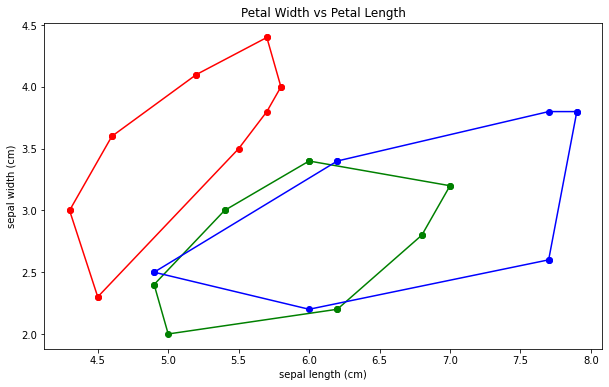

In [39]:
plt.figure(figsize = (10, 6))
colors = ['r', 'g', 'b']

plt.title('Petal Width vs Petal Length')

data = datasets.load_iris()
df = pd.DataFrame(data.data, columns = data.feature_names)
df['Target'] = pd.DataFrame(data.target)

plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])

for i in range(len(data.target_names)): # tadi diedit dari length(data.target_names)
    bucket = df[df['Target'] == i].iloc[:, [0, 1]].values
    up, down = myConvexHull(bucket)
    listXUp = []
    listYUp = []
    listXDown = []
    listYDown = []
    for j in range(len(down)):
        if down[j] != None:
            listXDown.append(down[j].x)
            listYDown.append(down[j].y)
    hullDown = [listXDown, listYDown]
    plt.scatter(hullDown[0], hullDown[1], color = colors[i])
    plt.plot(hullDown[0], hullDown[1], color = colors[i])
    for j in range(len(up)):
        if up[j] != None:
            listXUp.append(up[j].x)
            listYUp.append(up[j].y)
    hullUp = [listXUp, listYUp]
    plt.scatter(hullUp[0], hullUp[1], color = colors[i])
    plt.plot(hullUp[0], hullUp[1], color = colors[i])
plt.show()

[41 13]
[36 41]
[22 13]
[22 32]
[15 14]
[15 32]
[18 14]
[18 36]
 
[35  0]
[34  7]
[34 35]
[10  7]
[10 18]
[26  0]
[26 18]
 
[19  6]
[18 31]
[18 19]
[48  6]
[17 31]
[17 48]
 


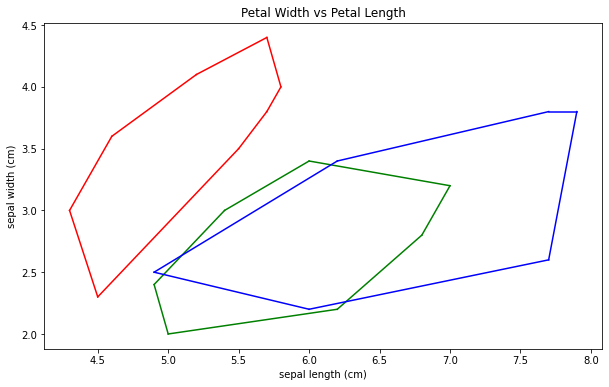

In [40]:
plt.figure(figsize = (10, 6))
colors = ['r', 'g', 'b']

plt.title('Petal Width vs Petal Length')

data = datasets.load_iris()
df = pd.DataFrame(data.data, columns = data.feature_names)
df['Target'] = pd.DataFrame(data.target)

plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])

for i in range(len(data.target_names)):
    bucket = df[df['Target'] == i].iloc[:, [0, 1]].values
    hull = ConvexHull(bucket)
    for simplex in hull.simplices:
        print(simplex)
        plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i])
    print(" ")
plt.show()